# Python | Ciência de Dados | Aprendizado de Máquina | Programação Genética

**Autor**: Alexandre Fortes Santana

**Palavras chaves**: ciência de dados, tratamento de dados, preparo de dados, manipulação de datasets, aprendizado de máquina, programação genética

# Dataset: Fórmula 1 (1950 - 2023)

Data set selecionado: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=results.csv

"**About Dataset**

**Context**

"*Formula 1 (a.k.a. F1 or Formula One) is the highest class of single-seater auto racing sanctioned by the Fédération Internationale de l'Automobile (FIA) and owned by the Formula One Group. The FIA Formula One World Championship has been one of the premier forms of racing around the world since its inaugural season in 1950. The word "formula" in the name refers to the set of rules to which all participants' cars must conform. A Formula One season consists of a series of races, known as Grands Prix, which take place worldwide on purpose-built circuits and on public roads.*"

**Content**

"*The dataset consists of all information on the Formula 1 races, drivers, constructors, qualifying, circuits, lap times, pit stops, championships from 1950 till the latest 2023 season.*"

**Acknowledgements**

"*The data is compiled from http://ergast.com/mrd/*"

**Inspiration**

"*Races are won at the track. Championships are won at the factory." - Mercedes (2019)

With the amount of data being captured, analyzed and used to design, build and drive the Formula 1 cars is astounding. It is a global sport being followed by millions of people worldwide and it is very fascinating to see drivers pushing their limit in these vehicles to become the fastest racers in the world!*"

---

Todas as bases se encontram replicadas no repositório do projeto:
https://github.com/alexandrefortes/Python-para-Ciencia-de-Dados

## Carregamento e preparo dos dados

In [1]:
import pandas as pd
import numpy as np

# Remove display limit
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

df_race_results = pd.read_csv('F1/results.csv').add_prefix('result_')
df_races = pd.read_csv('F1/races.csv').add_prefix('race_')
df_constructors = pd.read_csv('F1/constructors.csv').add_prefix('constructor_')
df_drivers = pd.read_csv('F1/drivers.csv').add_prefix('driver_')

# Merge
merged_df = pd.merge(df_race_results, df_races, left_on='result_raceId', right_on='race_raceId', how='left')
merged_df = pd.merge(merged_df, df_drivers, left_on='result_driverId', right_on='driver_driverId', how='left')
merged_df = pd.merge(merged_df, df_constructors, left_on='result_constructorId', right_on='constructor_constructorId', how='left')

# Adjusting some column names for better readability
merged_df.rename(columns={'result_grid': 'result_stating_grid', 'result_positionOrder' : 'result_final_position', 'driver_driverRef' : 'driver_name'}, inplace=True)
# Remove not used collumns
merged_df.drop(['result_laps', 'driver_forename', 'driver_surname', 'constructor_constructorId','constructor_constructorRef','constructor_url','driver_code','driver_dob','driver_driverId','driver_number','race_circuitId','race_date','race_fp1_date','race_fp1_time','race_fp2_date','race_fp2_time','race_fp3_date','race_fp3_time','race_quali_date','race_quali_time','race_raceId','race_round','race_sprint_date','race_sprint_time','race_time','result_constructorId','result_driverId','result_fastestLap','result_fastestLapSpeed','result_fastestLapTime','result_milliseconds','result_number','result_position','result_positionText','result_raceId','result_rank','result_statusId','result_time'], axis=1, inplace=True)

# Create a new collumn 'win' with 'True' if 'result_final_position' is 1 and 'False' otherwise
merged_df['win'] = merged_df['result_final_position'] == 1
# Create a new collumn 'podium_finish' with 'True' if 'result_final_position' is <= 3
merged_df['podium_finish'] = merged_df['result_final_position'].apply(lambda x: True if x <= 3 else False)

### Avaliar a poporção de dados faltantes

In [2]:
nan_proportion = merged_df.isna().mean()
nan_proportion

result_resultId            0.0
result_stating_grid        0.0
result_final_position      0.0
result_points              0.0
race_year                  0.0
race_name                  0.0
race_url                   0.0
driver_name                0.0
driver_nationality         0.0
driver_url                 0.0
constructor_name           0.0
constructor_nationality    0.0
win                        0.0
podium_finish              0.0
dtype: float64

### Avaliar tipo dos dados

In [3]:
print(merged_df.dtypes)

result_resultId              int64
result_stating_grid          int64
result_final_position        int64
result_points              float64
race_year                    int64
race_name                   object
race_url                    object
driver_name                 object
driver_nationality          object
driver_url                  object
constructor_name            object
constructor_nationality     object
win                           bool
podium_finish                 bool
dtype: object


### Análise Descritiva

In [4]:
merged_df.describe()

result_resultId  result_stating_grid  result_final_position   
count     25840.000000         25840.000000           25840.000000  \
mean      12921.334327            11.179063              12.876006   
std        7460.682031             7.243725               7.712391   
min           1.000000             0.000000               1.000000   
25%        6460.750000             5.000000               6.000000   
50%       12920.500000            11.000000              12.000000   
75%       19380.250000            17.000000              18.000000   
max       25845.000000            34.000000              39.000000   

       result_points     race_year  
count   25840.000000  25840.000000  
mean        1.877053   1990.251780  
std         4.169849     19.345632  
min         0.000000   1950.000000  
25%         0.000000   1976.000000  
50%         0.000000   1990.000000  
75%         2.000000   2007.000000  
max        50.000000   2022.000000

# Análises Gráficas

## Performance de contrutores por ano

Vamos analisar como foi a jornada das equipes com maior número de vitórias da história da Fórmula 1 até este momento.

### Prepara dados das equipes

In [5]:
# Calculate total races per year
total_races_per_year = merged_df.groupby('race_year')['race_name'].nunique().rename('total_races')

# Group by year, sum wins and total points
wins_and_points_per_constructor = merged_df.groupby(['race_year', 'constructor_name']).agg({'win': 'sum', 'result_points': 'sum'}) 

# Rename for clarity
wins_and_points_per_constructor.rename(columns={'win': 'wins', 'result_points': 'total_points'}, inplace=True)

# Reset index to merge with total_races_per_year
wins_and_points_per_constructor = wins_and_points_per_constructor.reset_index()

# Merge with total_races_per_year to include total races in each year
wins_and_points_per_constructor = wins_and_points_per_constructor.merge(total_races_per_year, on='race_year')

# Calculate average points
wins_and_points_per_constructor['average_points'] = wins_and_points_per_constructor['total_points'] / wins_and_points_per_constructor['total_races']

# For each year, get top 3 constructors with most wins
wins_and_points_per_constructor = wins_and_points_per_constructor.groupby('race_year').apply(lambda x: x.nlargest(3, 'wins')).reset_index(drop=True)

# Remove constructors with no wins
wins_and_points_per_constructor = wins_and_points_per_constructor[wins_and_points_per_constructor['wins'] > 0]

In [6]:
wins_and_points_per_constructor.describe()

race_year      wins  total_points  total_races  average_points
count   210.000000  210.0000    210.000000   210.000000      210.000000
mean   1985.861905    4.8000    157.102619    14.785714        9.476317
std      20.865139    3.6743    172.006245     3.957524        8.077438
min    1950.000000    1.0000      8.000000     7.000000        0.937500
25%    1968.000000    2.0000     62.250000    11.000000        4.439236
50%    1985.500000    4.0000     87.500000    16.000000        6.468750
75%    2003.750000    6.0000    155.750000    17.000000       10.237500
max    2022.000000   19.0000    765.000000    22.000000       37.000000

### Análise de vitórias

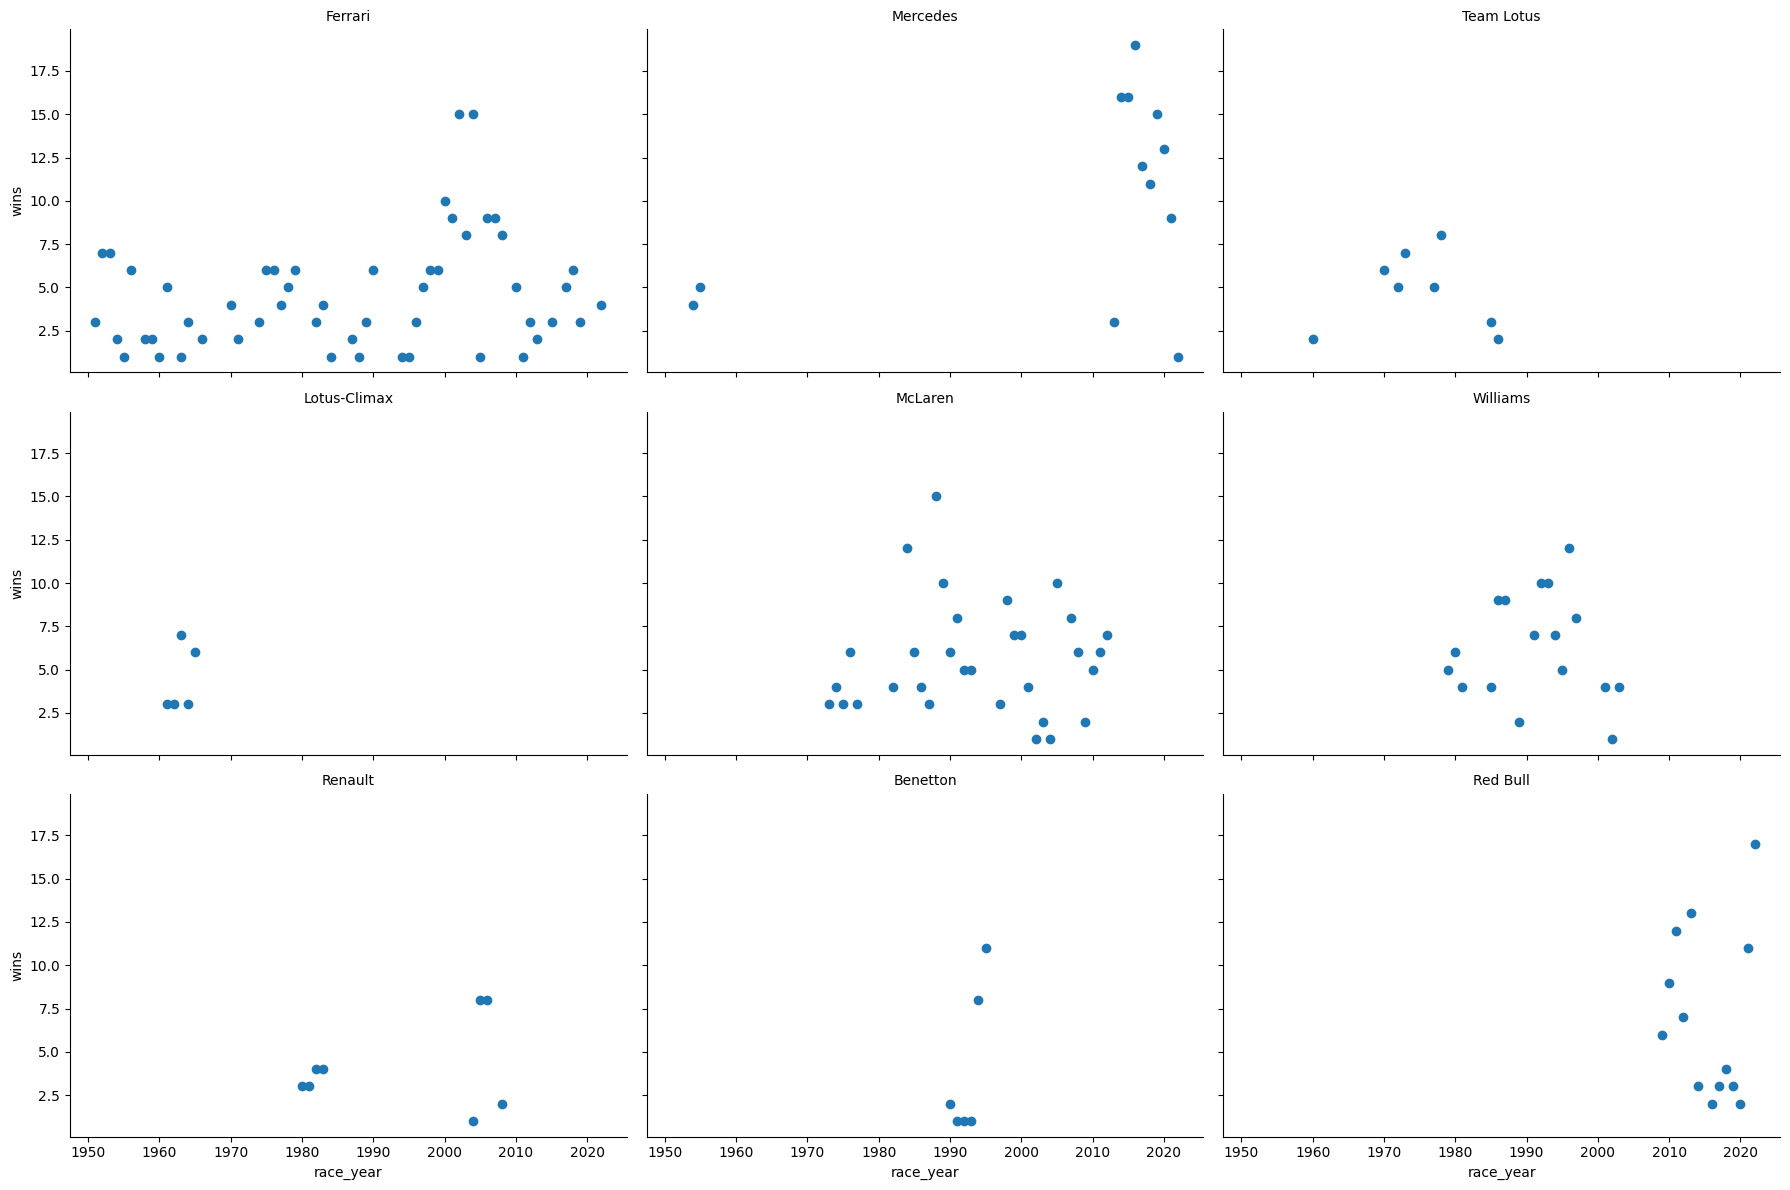

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 9 Top contrutores
top_constructors_to_plot = wins_and_points_per_constructor.groupby('constructor_name')['wins'].sum().nlargest(9).index

# Extrai dados destes construtores
wins_and_points_per_constructor_to_plot = wins_and_points_per_constructor[wins_and_points_per_constructor['constructor_name'].isin(top_constructors_to_plot)]

# FacetGrid 
g = sns.FacetGrid(wins_and_points_per_constructor_to_plot, col='constructor_name', col_wrap=3, height=4, aspect=1.5)

# Uma equipe por bloco
g = g.map(plt.scatter, 'race_year', 'wins')

# Add título
g = g.set_titles("{col_name}")

### Análise da média de pontos

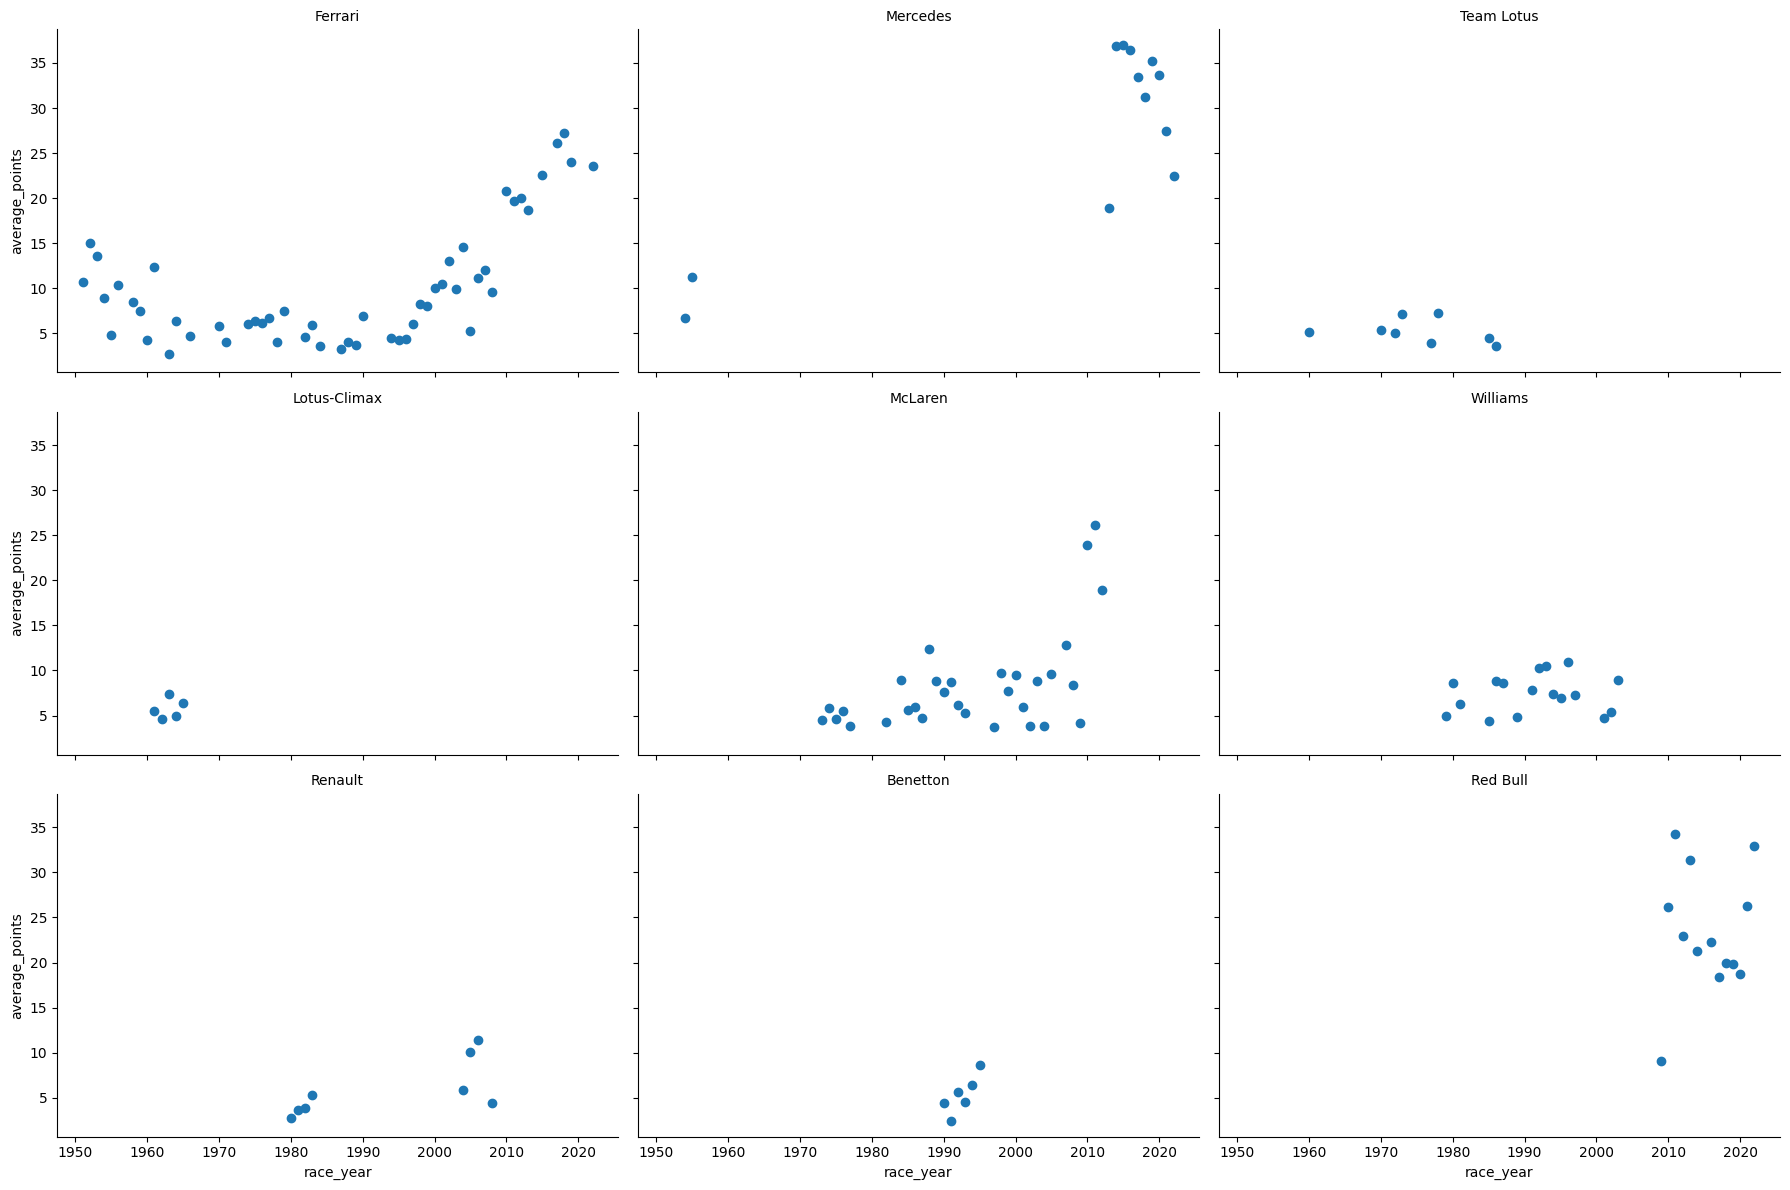

In [8]:
# FacetGrid 
g = sns.FacetGrid(wins_and_points_per_constructor_to_plot, col='constructor_name', col_wrap=3, height=4, aspect=1.5)

# Uma equipe por bloco
g = g.map(plt.scatter, 'race_year', 'average_points')

# Add título
g = g.set_titles("{col_name}")

## Performance de pilotos por ano

Vamos analisar como foi a jornada dos pilotos com maior número de vitórias da história da Fórmula 1 até este momento.

### Prepara dados dos pilotos

In [9]:
# Calculate total races per year
total_races_per_year = merged_df.groupby('race_year')['race_name'].nunique().rename('total_races')

# Group by year, sum wins and total points
wins_and_points_per_driver = merged_df.groupby(['race_year', 'driver_name']).agg({'win': 'sum', 'result_points': 'sum'}) 

# Rename for clarity
wins_and_points_per_driver.rename(columns={'win': 'wins', 'result_points': 'total_points'}, inplace=True)

# Reset index to merge with total_races_per_year
wins_and_points_per_driver = wins_and_points_per_driver.reset_index()

# Merge with total_races_per_year to include total races in each year
wins_and_points_per_driver = wins_and_points_per_driver.merge(total_races_per_year, on='race_year')

# Calculate average points
wins_and_points_per_driver['average_points'] = wins_and_points_per_driver['total_points'] / wins_and_points_per_driver['total_races']

# For each year, get top 3 drivers with most wins
wins_and_points_per_driver = wins_and_points_per_driver.groupby('race_year').apply(lambda x: x.nlargest(3, 'wins')).reset_index(drop=True)

# Remove drivers with no wins
wins_and_points_per_driver = wins_and_points_per_driver[wins_and_points_per_driver['wins'] > 0]

In [10]:
wins_and_points_per_driver.describe()

race_year        wins  total_points  total_races  average_points
count   219.000000  219.000000    219.000000   219.000000      219.000000
mean   1986.000000    3.977169     99.558995    14.780822        5.940498
std      21.119581    2.718342    103.550872     4.013440        4.801945
min    1950.000000    1.000000      4.000000     7.000000        0.464286
25%    1968.000000    2.000000     37.000000    11.000000        3.069712
50%    1986.000000    3.000000     60.000000    16.000000        4.312500
75%    2004.000000    5.000000     99.500000    17.000000        6.291667
max    2022.000000   15.000000    433.000000    22.000000       20.894737

### Análise de vitórias

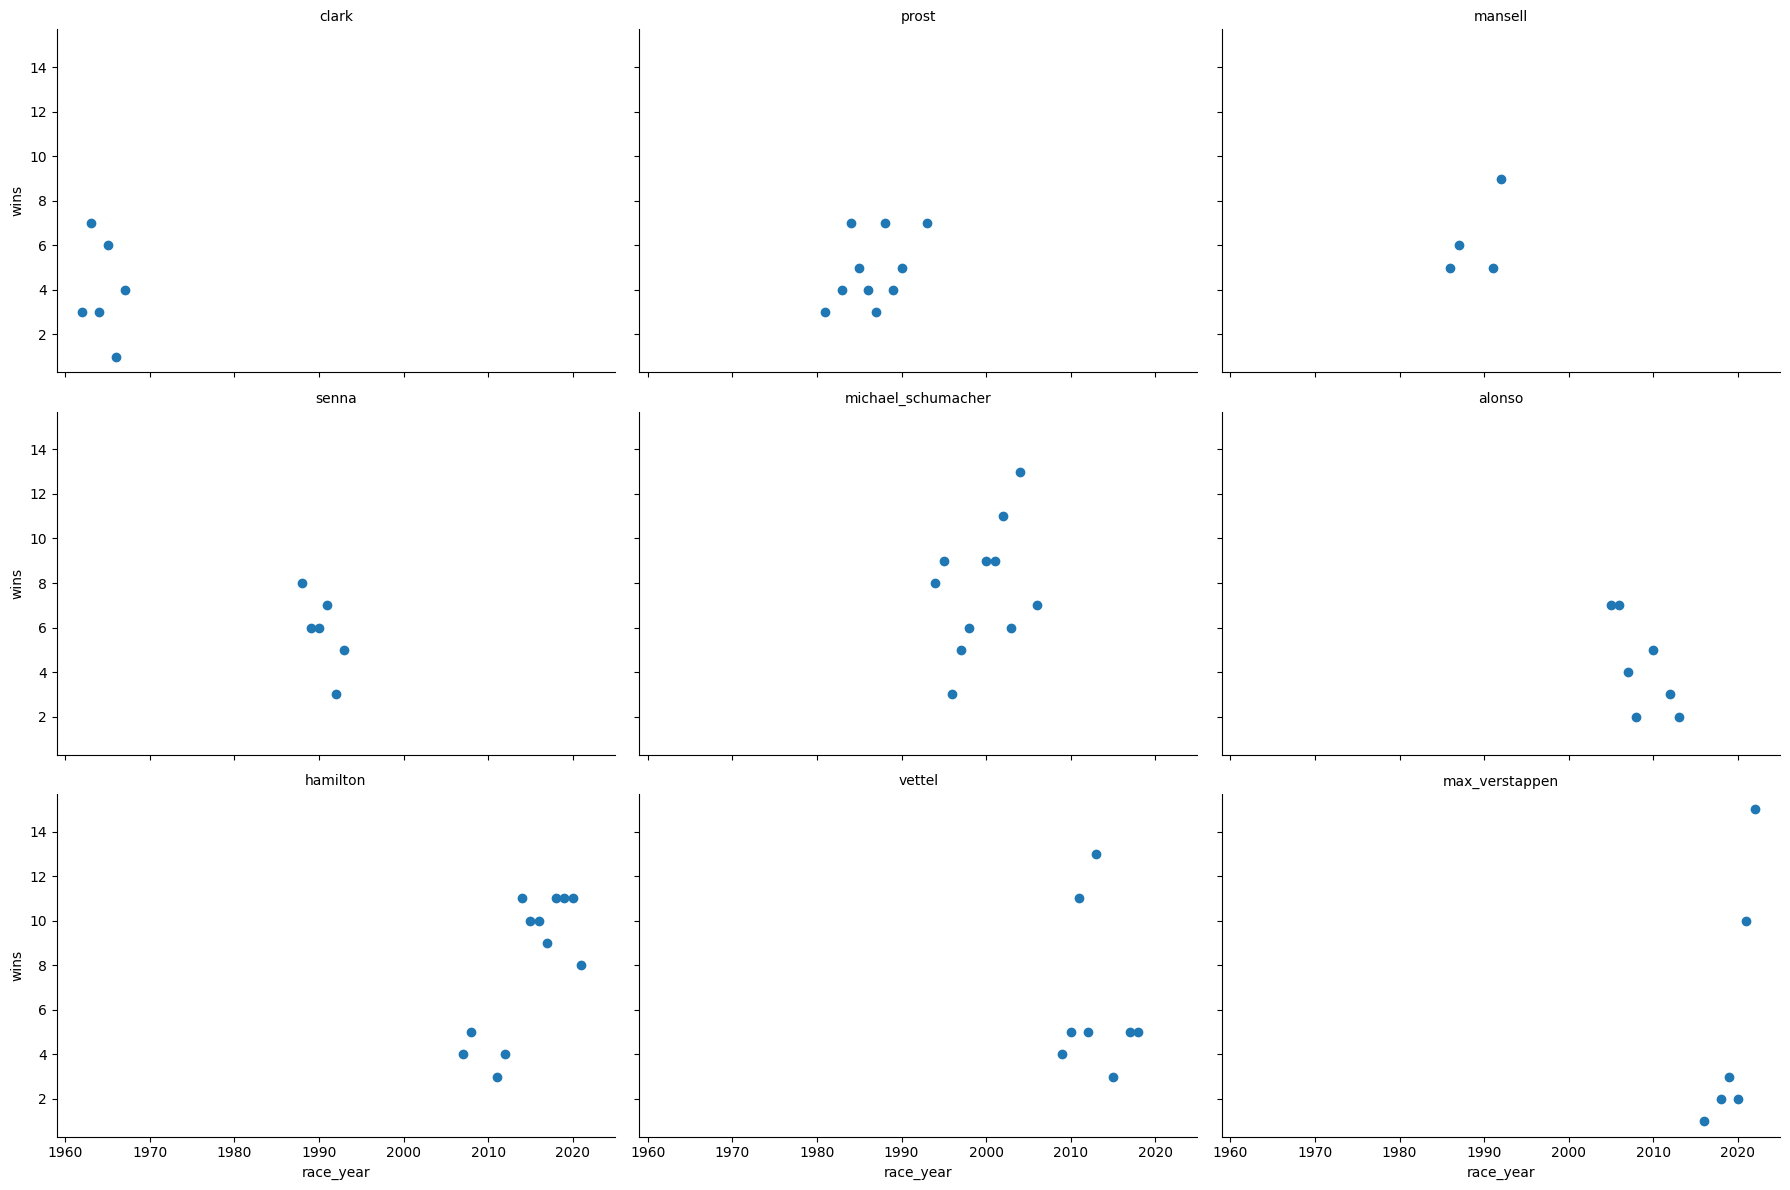

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 9 Top contrutores
top_drivers_to_plot = wins_and_points_per_driver.groupby('driver_name')['wins'].sum().nlargest(9).index

# Extrai dados destes construtores
wins_and_points_per_driver_to_plot = wins_and_points_per_driver[wins_and_points_per_driver['driver_name'].isin(top_drivers_to_plot)]

# FacetGrid 
g = sns.FacetGrid(wins_and_points_per_driver_to_plot, col='driver_name', col_wrap=3, height=4, aspect=1.5)

# Uma equipe por bloco
g = g.map(plt.scatter, 'race_year', 'wins')

# Add título
g = g.set_titles("{col_name}")

### Análise da média de pontos

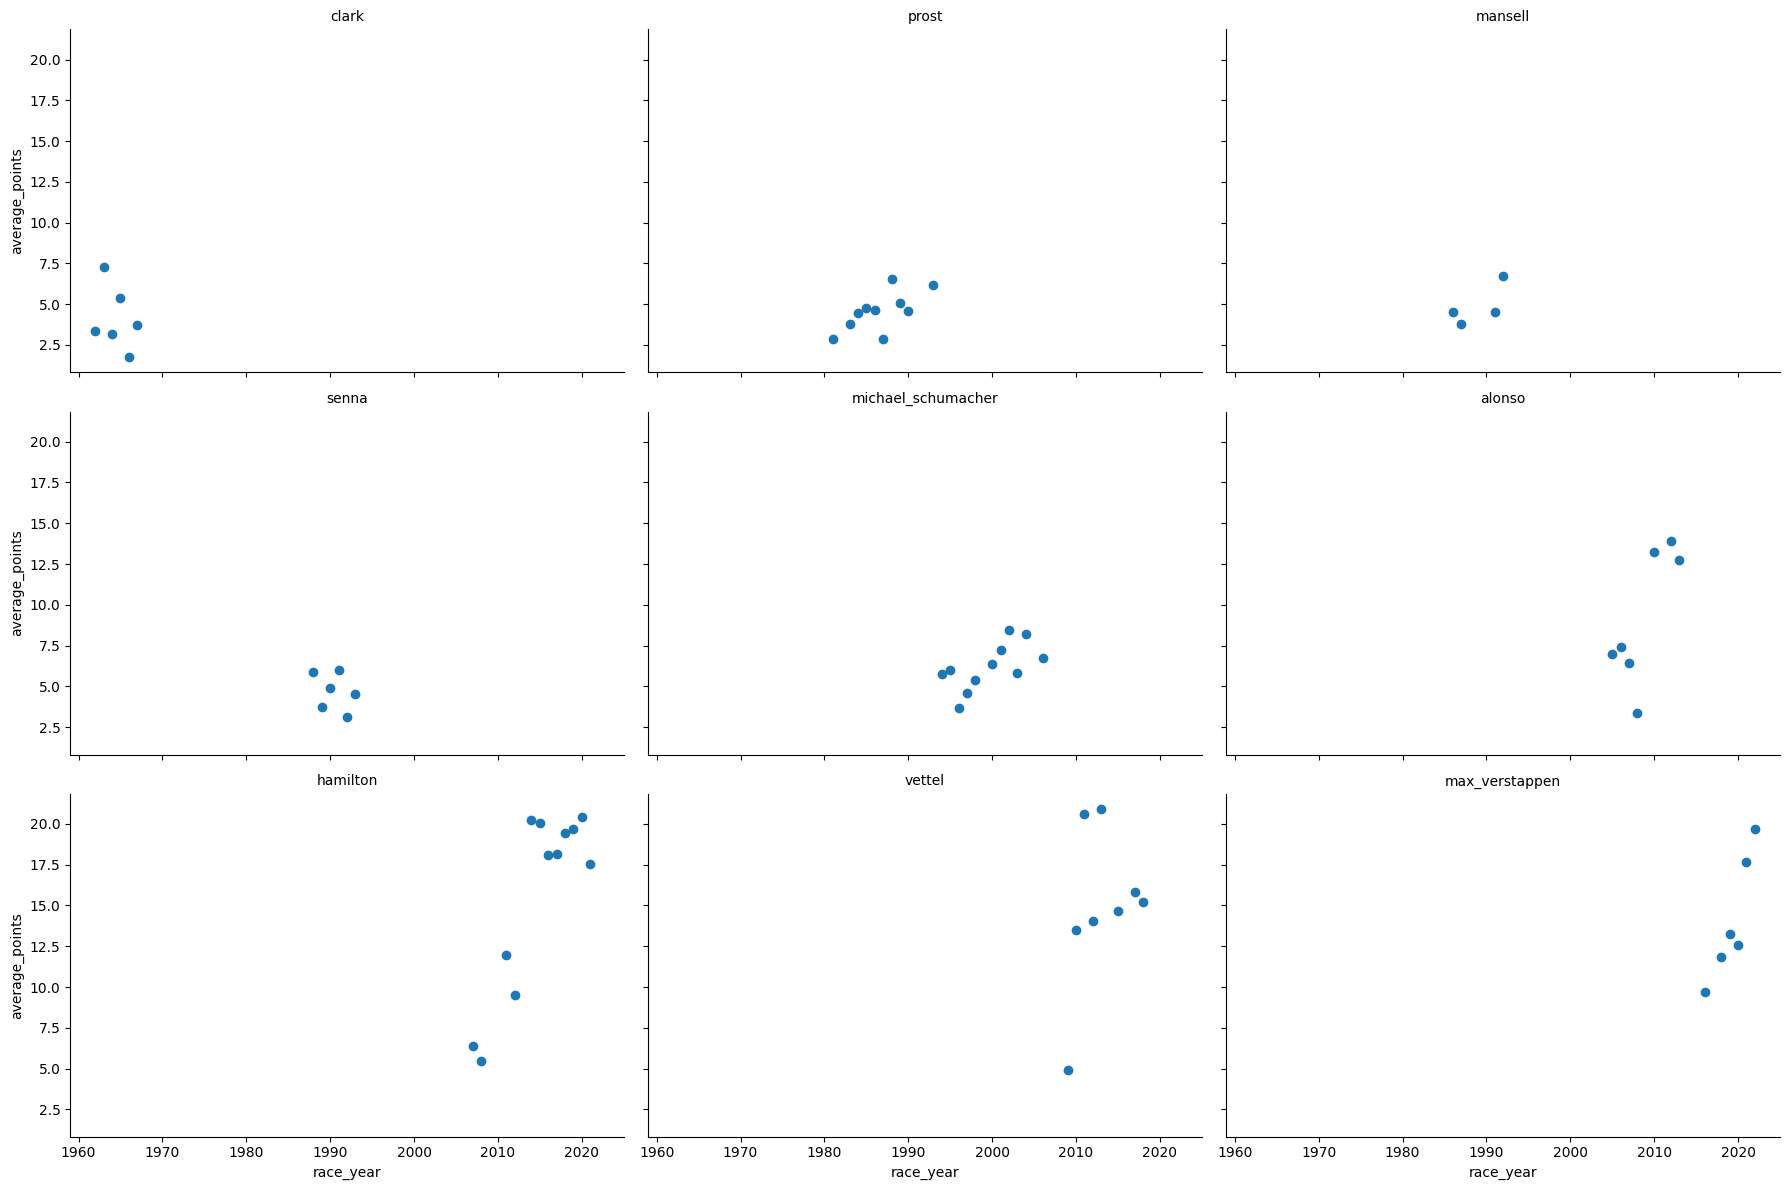

In [12]:
# FacetGrid 
g = sns.FacetGrid(wins_and_points_per_driver_to_plot, col='driver_name', col_wrap=3, height=4, aspect=1.5)

# Uma equipe por bloco
g = g.map(plt.scatter, 'race_year', 'average_points')

# Add título
g = g.set_titles("{col_name}")

## Influência do grid de largada no resultado final

Text(0, 0.5, 'Final Position')

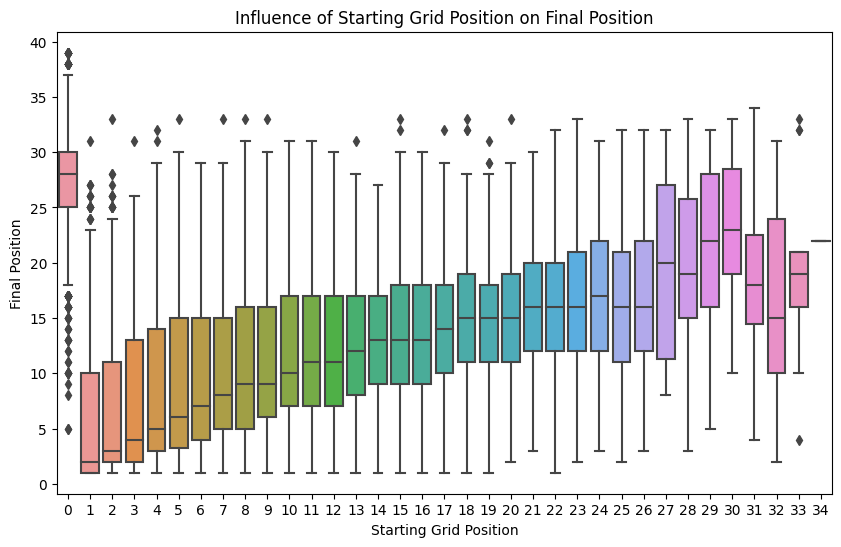

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='result_stating_grid', y='result_final_position', data=merged_df)
plt.title('Influence of Starting Grid Position on Final Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Final Position')

# Aplicando métdos de aprendizado para Classificação

A análise de dados da Fórmula 1 é bastante complexa. Entretanto, estamos usando um modelo de classificação simples para prever se um piloto: 

1. erminará no podium (top 3)
2. pontuará (posição final entre 4 e 10), ou 
3. não pontuará (posição final maior que 10)

Baseado em:
1. quem é o piloto
2. equipe do piloto
3. sua posição inicial (grid)
4. circuito (local da corrida)

result_resultId              int64
result_stating_grid          int64
result_final_position        int64
result_points              float64
race_year                    int64
race_name                   object
race_url                    object
driver_name                 object
driver_nationality          object
driver_url                  object
constructor_name            object
constructor_nationality     object
win                           bool

## Testando com LabelEncoder

### Preparo dos dados

In [14]:
merged_df_encoded = merged_df.copy()
merged_df_encoded.drop(['result_resultId', 'race_year', 'race_url', 'driver_nationality', 'driver_url', 'constructor_nationality'], axis=1, inplace=True)

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in merged_df_encoded.columns:
    if merged_df_encoded[col].dtype == 'object':
        merged_df_encoded[col] = le.fit_transform(merged_df_encoded[col].astype(str))

### Distribuição Considerando classe "win"

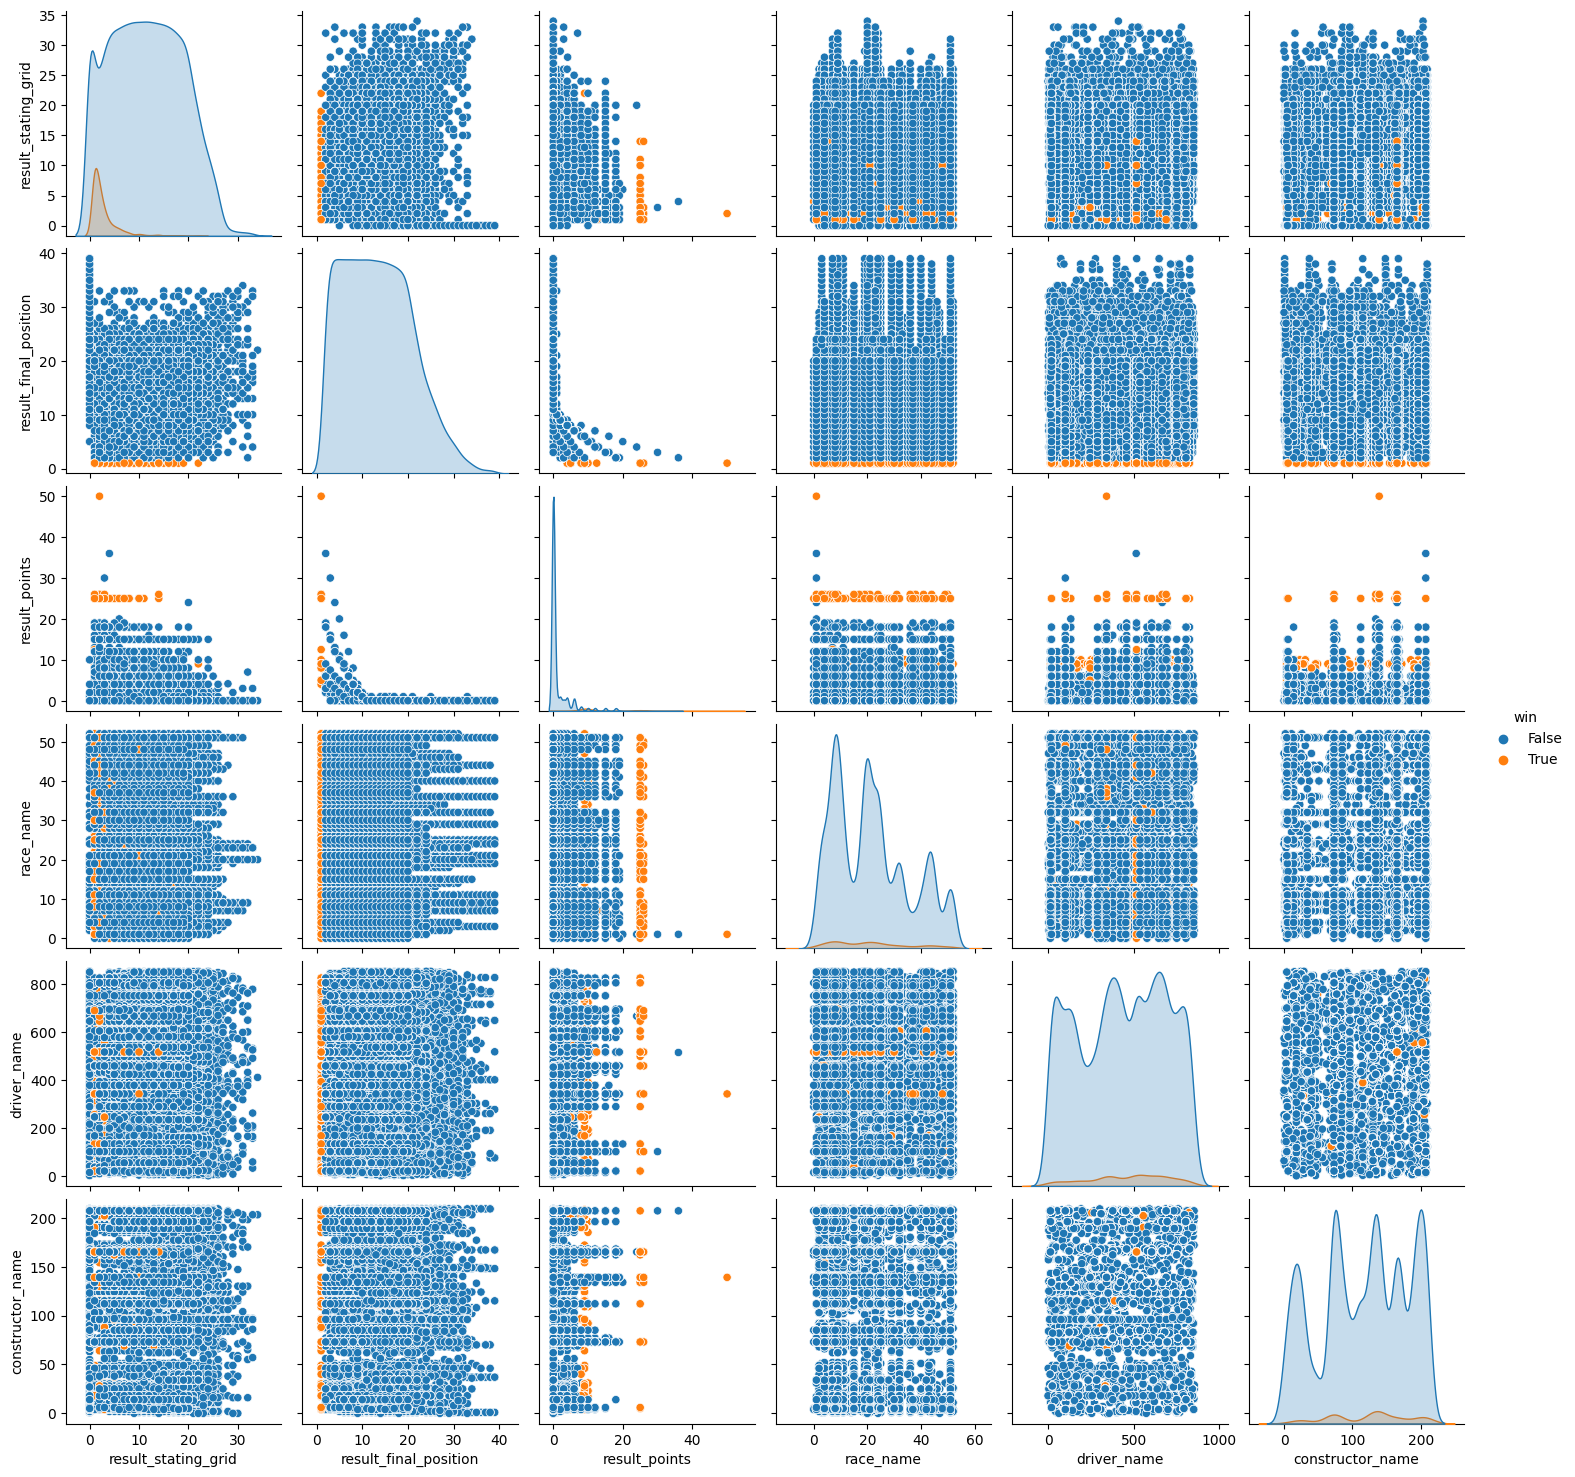

In [15]:
columns_to_plot1 = ['win', 'result_stating_grid', 'result_final_position', 'result_points', 'race_name', 'driver_name', 'constructor_name']
sns.pairplot(merged_df_encoded[columns_to_plot1],hue='win')

### Distribuição Considerando "podium_finish"

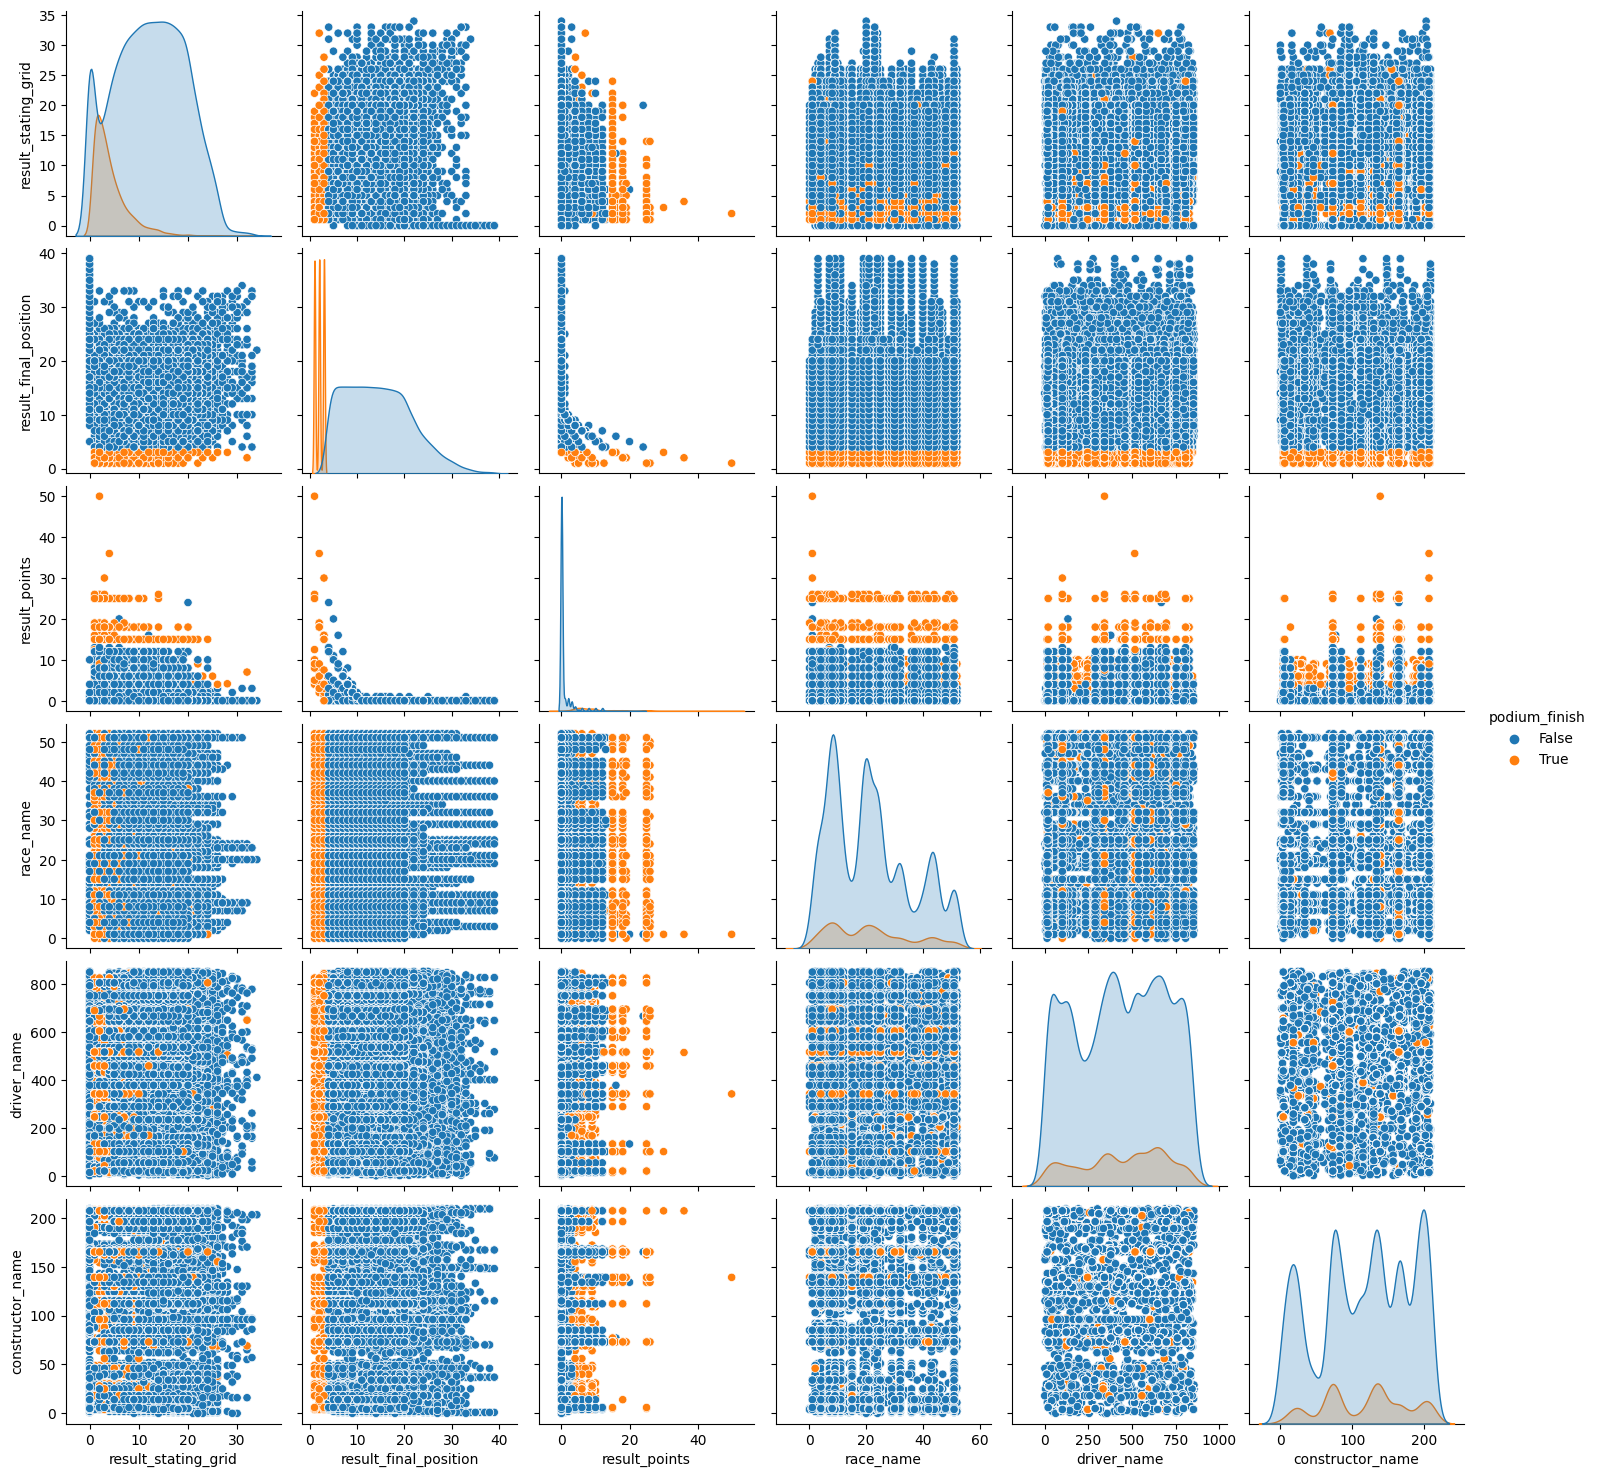

In [16]:
columns_to_plot1 = ['podium_finish', 'result_stating_grid', 'result_final_position', 'result_points', 'race_name', 'driver_name', 'constructor_name']
sns.pairplot(merged_df_encoded[columns_to_plot1],hue='podium_finish')

### Aplicando Modelos de Aprendizado

Verificando balanceamento da classe "podium_finish":

In [17]:
# Check the balance of the 'podium_finish' column
counts = merged_df_encoded['podium_finish'].value_counts(normalize=True)
print(counts)

podium_finish
False    0.873878
True     0.126122
Name: proportion, dtype: float64


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [19]:
X = merged_df_encoded.drop('podium_finish', axis=1)
y = merged_df_encoded['podium_finish']

In [32]:
clfs = [DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        KNeighborsClassifier()]

from sklearn.model_selection import cross_val_score

classifiers = []
scores = []

for clf in clfs:
    cv_scores = cross_val_score(clf,X,y, cv=10, scoring='f1', n_jobs=-1)
    for s in cv_scores:
        classifiers.append(str(clf))
        scores.append(float(s))

results = pd.DataFrame({'classifier':classifiers,'F-score':scores})
results

classifier   F-score
0   DecisionTreeClassifier()  1.000000
1   DecisionTreeClassifier()  1.000000
2   DecisionTreeClassifier()  1.000000
3   DecisionTreeClassifier()  1.000000
4   DecisionTreeClassifier()  1.000000
5   DecisionTreeClassifier()  1.000000
6   DecisionTreeClassifier()  1.000000
7   DecisionTreeClassifier()  1.000000
8   DecisionTreeClassifier()  1.000000
9   DecisionTreeClassifier()  1.000000
10  RandomForestClassifier()  1.000000
11  RandomForestClassifier()  1.000000
12  RandomForestClassifier()  1.000000
13  RandomForestClassifier()  1.000000
14  RandomForestClassifier()  1.000000
15  RandomForestClassifier()  1.000000
16  RandomForestClassifier()  1.000000
17  RandomForestClassifier()  1.000000
18  RandomForestClassifier()  1.000000
19  RandomForestClassifier()  1.000000
20                     SVC()  0.538117
21                     SVC()  0.443914
22                     SVC()  0.345178
23                     SVC()  0.270557
24                     SVC()  0.349367
25                     SVC()  0.310881
26                     SVC()  0.370000
27                     SVC()  0.554585
28                     SVC()  0.846154
29                     SVC()  0.803549
30    KNeighborsClassifier()  0.577540
31    KNeighborsClassifier()  0.661792
32    KNeighborsClassifier()  0.599190
33    KNeighborsClassifier()  0.618395
34    KNeighborsClassifier()  0.556452
35    KNeighborsClassifier()  0.438247
36    KNeighborsClassifier()  0.337761
37    KNeighborsClassifier()  0.610738
38    KNeighborsClassifier()  0.710456
39    KNeighborsClassifier()  0.757047

<Axes: xlabel='classifier', ylabel='F-score'>

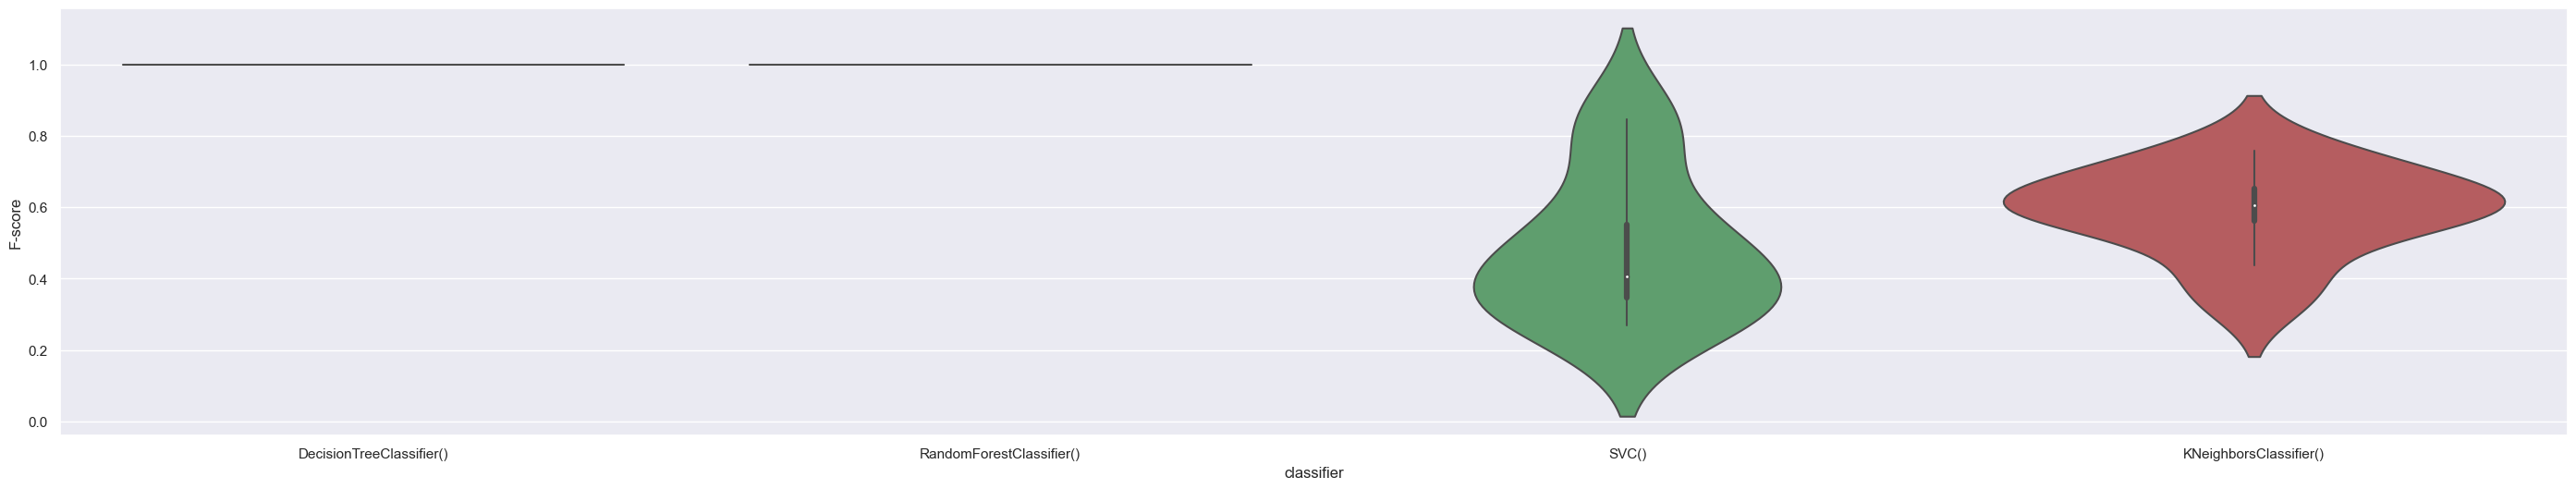

In [33]:
sns.set(rc={'figure.figsize':(35,6)})
sns.violinplot(data=results,x='classifier',y='F-score')

### Identificando melhores hyperparâmetros para RandomForestClassifier

Apenas para efeitos didáticos, visto que o modelo inicialmente já apresentou F-score igual a 1.

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini','entropy','log_loss'],
              'max_depth':[2,3,4,5,6,7,8,9,10],
              }

grid = GridSearchCV(RandomForestClassifier(),param_grid,cv=10,scoring='f1', n_jobs=-1)
grid.fit(X,y)
grid.best_params_

{'criterion': 'gini', 'max_depth': 3}

In [ ]:
# Ponto de parada
#import sys
#sys.exit()

### Identificando melhores hyperparâmetros para SVC

Como as classes estão desequilibradas, decidi usar o scoring "f1_macro" pois calcula as métricas para cada classe individualmente e depois faz a média delas, tratando todas as classes de forma igual, independentemente de sua frequência. 

In [ ]:
#não consegui rodar, demorando muito:
""" param_grid = {'kernel':['poly', 'rbf', 'sigmoid'],
              'degree':[2,3,4,5],
              'gamma':['scale','auto'],
              'C':[0.1,0.5,1,1.5,2]}

grid = GridSearchCV(SVC(),param_grid,cv=4,scoring='f1_macro', n_jobs=-1)
grid.fit(X,y)
grid.best_params_ """

### Identificando melhores hyperparâmetros para KNeighborsClassifier

In [27]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

grid = GridSearchCV(KNeighborsClassifier(),param_grid,cv=10,scoring='f1_macro', n_jobs=-1)
grid.fit(X,y)
grid.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

### Retreinando o modelo com os hyperparâmetros

classifier   F-score
0  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.646766
1  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.712095
2  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.755793
3  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.767606
4  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.726944
5  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.544790
6  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.535354
7  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.693624
8  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.765840
9  KNeighborsClassifier(n_neighbors=3, p=1, weigh...  0.788732

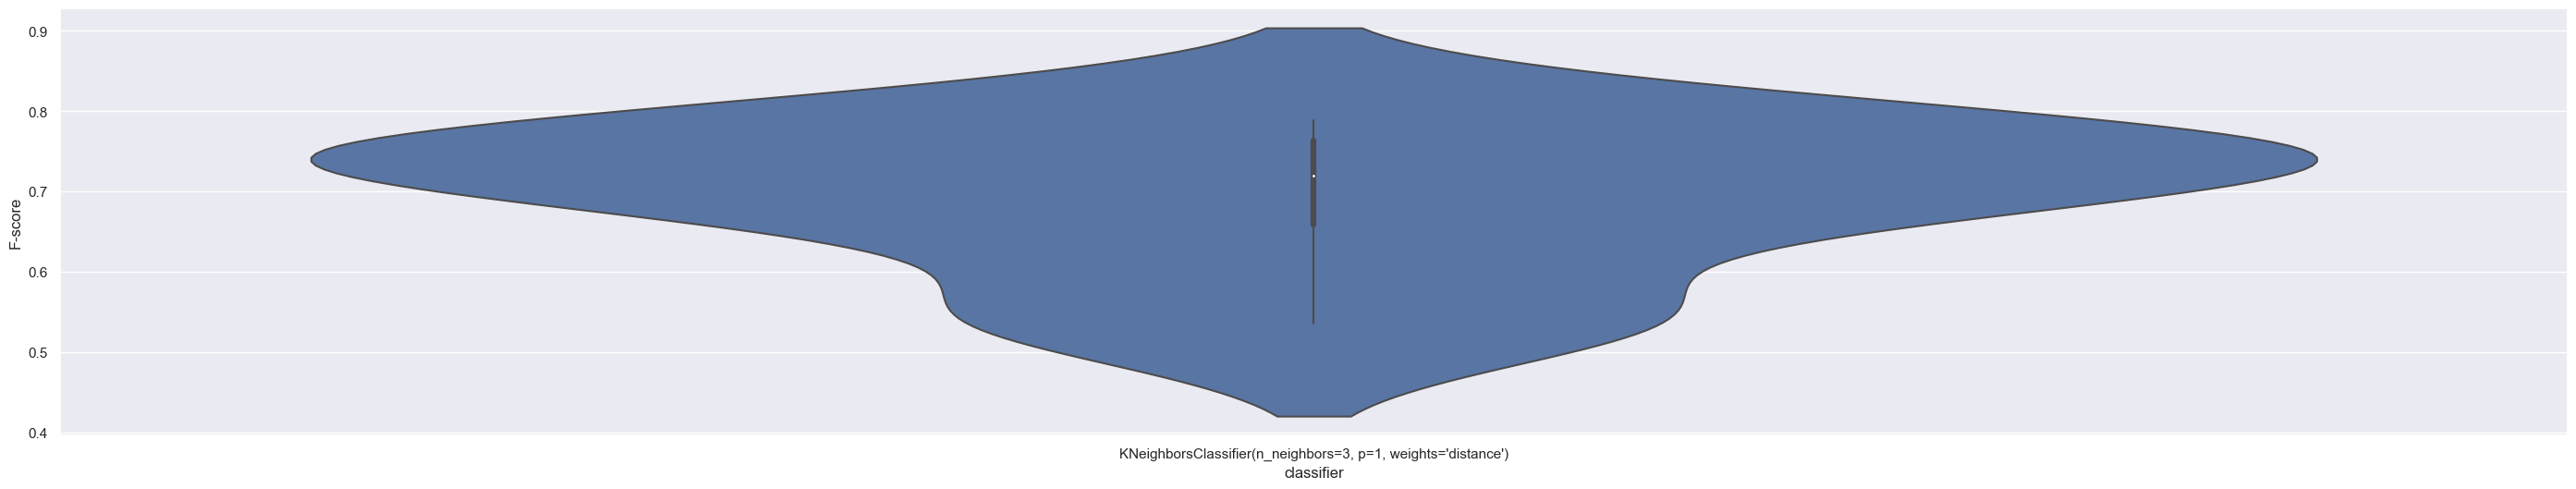

In [34]:
clfs = [KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')]

from sklearn.model_selection import cross_val_score

classifiers = []
scores = []

for clf in clfs:
    cv_scores = cross_val_score(clf,X,y, cv=10, scoring='f1')
    for s in cv_scores:
        classifiers.append(str(clf))
        scores.append(float(s))

results = pd.DataFrame({'classifier':classifiers,'F-score':scores})

sns.set(rc={'figure.figsize':(35,6)})
sns.violinplot(data=results,x='classifier',y='F-score')
results

In [ ]:
# Ponto de parada
import sys
sys.exit()

# Testando com One Hot Encoder

In [ ]:
merged_df_ohe=merged_df.copy()
merged_df_ohe.drop(['result_resultId', 'race_year', 'race_url', 'driver_nationality', 'driver_url', 'constructor_nationality'], axis=1, inplace=True)

# Convert the boolean columns to int
merged_df_ohe['win'] = merged_df_ohe['win'].astype(int)
merged_df_ohe['podium_finish'] = merged_df_ohe['podium_finish'].astype(int)

# Apply the One-Hot Encoding
merged_df_ohe = pd.get_dummies(merged_df_ohe, columns=['race_name', 'driver_name', 'constructor_name'])
merged_df_encoded.columns

# Testes antigos

## Modelo com 6 classes
'result_stating_grid', 'race_year', 'race_name', 'constructor_name', 'driver_driverRef', 'podium'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Clean and prepare the data
# Converting the field 'result_final_position' to numeric, replacing any problematic values with NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')

# Copying the original dataframe to use on training
merged_df_train = merged_df.copy()

# Remove reccords where the final position is unknown
merged_df_train = merged_df_train.dropna(subset=['result_final_position'])  

In [ ]:
# Convert final position to a binary var, 1 if the pilot finishes on podium (top 3), 0 otherwise
merged_df_train['podium'] = merged_df_train['result_final_position'].apply(lambda x: 1 if x <= 3 else 0)

# Select only the collumns that we want for the model
merged_df_train = merged_df_train[['result_stating_grid', 'race_year', 'race_name', 'constructor_name', 'driver_driverRef', 'podium']]

In [ ]:
# Convert categorical columns to numeric
race_name_le = LabelEncoder()
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()

# Converter colunas categóricas para numéricas
merged_df_train['race_name_num'] = race_name_le.fit_transform(merged_df_train['race_name'])
merged_df_train['constructor_name_num'] = constructor_name_le.fit_transform(merged_df_train['constructor_name'])
merged_df_train['driver_driverRef_num'] = driver_driverRef_le.fit_transform(merged_df_train['driver_driverRef'])

In [ ]:
# Copying the dataframe for conversion reference. We're doing this because we need to use the same mapping to convert new data that the user will provide.
df_train = merged_df_train.copy()  
df_train.drop(['race_name', 'constructor_name', 'driver_driverRef'], axis=1, inplace=True)

In [ ]:
# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trein the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2324
           1       0.55      0.55      0.55       674

    accuracy                           0.80      2998
   macro avg       0.71      0.71      0.71      2998
weighted avg       0.80      0.80      0.80      2998



In [ ]:
def predict_finish_in_points(starting_grid, race_year, race_name, constructor_name, driver_name):
    # Create a DataFrame with the input data
    race_name_num_predict = merged_df_train.query(f"race_name == '{race_name}'").iloc[0]['race_name_num']
    
    constructor_name_num_predict = merged_df_train.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    
    driver_driverRef_num_predict = merged_df_train.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']

    data_to_predict = pd.DataFrame({
        'result_stating_grid': [starting_grid],
        'race_year': [race_year],
        'race_name_num': [race_name_num_predict],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })

    data_to_predict
    
    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    print(f'driver_name: {driver_name}, starting grid: {starting_grid}, race_year: {race_year}, Circuito: {race_name}, constructor_name: {constructor_name} ==> {"Finish in podium" if prediction == 1 else "Not finish in podium"}')


Gerando strings de teste

In [ ]:
import random
import pandas as pd

# From merged_df_train dataframe

for _ in range(50):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1975, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_train.sample(n=1)

    # Extract the values for race_name_num, constructor_name_num, and driver_driverRef_num
    race_name_num = row['race_name'].values[0]
    constructor_name_num = row['constructor_name'].values[0]
    driver_driverRef_num = row['driver_driverRef'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, {year}, "{race_name_num}", "{constructor_name_num}", "{driver_driverRef_num}")'
    print(code_string)


Fazendo previsões

In [ ]:
predict_finish_in_points(10, 2008, 'Australian Grand Prix', 'McLaren', 'hamilton')
predict_finish_in_points(4, 2008, 'Australian Grand Prix', 'Mercedes', 'hamilton')
predict_finish_in_points(12, 2005, "Canadian Grand Prix", "Stewart", "herbert")
predict_finish_in_points(4, 1991, "French Grand Prix", "McLaren", "prost")
predict_finish_in_points(5, 2018, "Dutch Grand Prix", "McLaren", "lunger")
predict_finish_in_points(8, 2010, "Australian Grand Prix", "Jaguar", "irvine")
predict_finish_in_points(24, 2011, "British Grand Prix", "Vanwall", "lewis-evans")
predict_finish_in_points(4, 2005, "United States Grand Prix", "Williams", "massa")
predict_finish_in_points(17, 1984, "Austrian Grand Prix", "McLaren", "watson")
predict_finish_in_points(22, 2020, "Italian Grand Prix", "AFM", "hans_stuck")
predict_finish_in_points(4, 2020, "Austrian Grand Prix", "Ferrari", "ickx")
predict_finish_in_points(12, 2016, "Monaco Grand Prix", "Ferrari", "massa")
predict_finish_in_points(6, 1979, "Mexican Grand Prix", "Ferrari", "vettel")
predict_finish_in_points(21, 2008, "Japanese Grand Prix", "McLaren", "hamilton")
predict_finish_in_points(17, 2008, "South African Grand Prix", "McLaren", "senna")
predict_finish_in_points(11, 2005, "French Grand Prix", "Minardi", "bruni")
predict_finish_in_points(4, 1985, "Spanish Grand Prix", "Footwork", "warwick")
predict_finish_in_points(4, 2002, "Italian Grand Prix", "Jordan", "barrichello")
predict_finish_in_points(11, 1975, "Belgian Grand Prix", "March", "naspetti")
predict_finish_in_points(13, 1996, "Malaysian Grand Prix", "McLaren", "hamilton")
predict_finish_in_points(10, 1988, "French Grand Prix", "Brabham-BRM", "taylor")
predict_finish_in_points(14, 1975, "Chinese Grand Prix", "Lotus", "trulli")
predict_finish_in_points(14, 1993, "Brazilian Grand Prix", "Red Bull", "webber")
predict_finish_in_points(21, 2019, "Bahrain Grand Prix", "Force India", "hulkenberg")
predict_finish_in_points(19, 1992, "Dutch Grand Prix", "Team Lotus", "rebaque")
predict_finish_in_points(3, 1993, "Chinese Grand Prix", "Sauber", "leclerc")
predict_finish_in_points(1, 2022, "Dutch Grand Prix", "Williams", "keke_rosberg")
predict_finish_in_points(15, 1995, "Hungarian Grand Prix", "Red Bull", "max_verstappen")
predict_finish_in_points(20, 1995, "Italian Grand Prix", "Ferrari", "lauda")
predict_finish_in_points(16, 2018, "British Grand Prix", "Cooper", "gerard")
predict_finish_in_points(14, 1987, "Mexican Grand Prix", "Red Bull", "max_verstappen")
predict_finish_in_points(22, 2019, "French Grand Prix", "Arrows", "surer")
predict_finish_in_points(21, 1978, "Italian Grand Prix", "Williams", "mansell")
predict_finish_in_points(6, 1983, "Portuguese Grand Prix", "Brabham", "piquet")
predict_finish_in_points(15, 2017, "Belgian Grand Prix", "Tyrrell", "cevert")
predict_finish_in_points(3, 2004, "Dutch Grand Prix", "Ligier", "laffite")
predict_finish_in_points(24, 2007, "Canadian Grand Prix", "Team Lotus", "ickx")
predict_finish_in_points(5, 1984, "Australian Grand Prix", "Renault", "sainz")
predict_finish_in_points(22, 2010, "Belgian Grand Prix", "March", "lauda")
predict_finish_in_points(1, 2010, "Canadian Grand Prix", "Caterham", "petrov")
predict_finish_in_points(23, 2002, "Dutch Grand Prix", "Mercedes", "fangio")
predict_finish_in_points(18, 1987, "Turkish Grand Prix", "BMW Sauber", "heidfeld")
predict_finish_in_points(5, 1979, "French Grand Prix", "Team Lotus", "satoru_nakajima")
predict_finish_in_points(3, 2008, "French Grand Prix", "Alfa Romeo", "giacomelli")
predict_finish_in_points(13, 1980, "Italian Grand Prix", "Toro Rosso", "vettel")
predict_finish_in_points(15, 1997, "United States Grand Prix", "Williams", "sirotkin")
predict_finish_in_points(4, 1994, "Austrian Grand Prix", "McLaren", "revson")
predict_finish_in_points(18, 1982, "Australian Grand Prix", "Mercedes", "rosberg")
predict_finish_in_points(20, 2016, "Mexican Grand Prix", "Sauber", "ericsson")
predict_finish_in_points(14, 2019, "Singapore Grand Prix", "Lotus F1", "maldonado")
predict_finish_in_points(4, 2021, "Bahrain Grand Prix", "Williams", "maldonado")
predict_finish_in_points(17, 1981, "European Grand Prix", "Red Bull", "vettel")


## Modelo com 4 classes

Vamos reduzir o número de campos para treinamento para piloto, equipe, grid de largada e podium.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Clean and prepare the data
# Converting the field 'result_final_position' to numeric, replacing any problematic values with NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')

# Copying the original dataframe to use on training
merged_df_train = merged_df.copy()

# Remove reccords where the final position is unknown
merged_df_train = merged_df_train.dropna(subset=['result_final_position'])  

# Convert final position to a binary var, 1 if the pilot finishes on podium (top 3), 0 otherwise
merged_df_train['podium'] = merged_df_train['result_final_position'].apply(lambda x: 1 if x <= 3 else 0)

# Select only the collumns that we want for the model
merged_df_train = merged_df_train[['result_stating_grid', 'constructor_name', 'driver_driverRef', 'podium']]

# Convert categorical columns to numeric
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()

# Converter colunas categóricas para numéricas
merged_df_train['constructor_name_num'] = constructor_name_le.fit_transform(merged_df_train['constructor_name'])
merged_df_train['driver_driverRef_num'] = driver_driverRef_le.fit_transform(merged_df_train['driver_driverRef'])

# Copying the dataframe for conversion reference. We're doing this because we need to use the same mapping to convert new data that the user will provide.
df_train = merged_df_train.copy()  
df_train.drop(['constructor_name', 'driver_driverRef'], axis=1, inplace=True)

# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trein the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2324
           1       0.61      0.55      0.58       674

    accuracy                           0.82      2998
   macro avg       0.74      0.73      0.73      2998
weighted avg       0.82      0.82      0.82      2998



### Função para testes

In [ ]:
def predict_finish_in_points(starting_grid, constructor_name, driver_name):
    # Create a DataFrame with the input data 
    constructor_name_num_predict = merged_df_train.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    driver_driverRef_num_predict = merged_df_train.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']

    data_to_predict = pd.DataFrame({
        'result_stating_grid': [starting_grid],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })
 
    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    print(f'driver_name: {driver_name}, starting grid: {starting_grid}, constructor_name: {constructor_name} ==> {"Finish in podium" if prediction == 1 else "Not finish in podium"}')

In [ ]:
# Gerando strings de teste
import random
import pandas as pd

# From merged_df_train dataframe

for _ in range(50):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1975, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_train.sample(n=1)

    # Extract the values for race_name_num, constructor_name_num, and driver_driverRef_num
    constructor_name_num = row['constructor_name'].values[0]
    driver_driverRef_num = row['driver_driverRef'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, "{constructor_name_num}", "{driver_driverRef_num}")'
    print(code_string)

predict_finish_in_points(12, "Red Bull", "ricciardo")
predict_finish_in_points(3, "Surtees", "mass")
predict_finish_in_points(21, "BRM", "baghetti")
predict_finish_in_points(10, "Force India", "resta")
predict_finish_in_points(24, "Mercedes", "rosberg")
predict_finish_in_points(5, "McLaren", "norris")
predict_finish_in_points(18, "Ligier", "laffite")
predict_finish_in_points(23, "Sauber", "ericsson")
predict_finish_in_points(6, "Ligier", "grouillard")
predict_finish_in_points(20, "Toro Rosso", "bourdais")
predict_finish_in_points(15, "Ferrari", "barrichello")
predict_finish_in_points(12, "Tyrrell", "brundle")
predict_finish_in_points(9, "Tyrrell", "depailler")
predict_finish_in_points(19, "Toro Rosso", "ricciardo")
predict_finish_in_points(11, "McLaren", "button")
predict_finish_in_points(21, "Minardi", "nakano")
predict_finish_in_points(22, "Virgin", "ambrosio")
predict_finish_in_points(18, "Williams", "mansell")
predict_finish_in_points(8, "Team Lotus", "angelis")
predict_finish_in_p

In [ ]:
# Fazendo previsões
predict_finish_in_points(12, "McLaren", "prost")
predict_finish_in_points(19, "Brabham", "piquet")
predict_finish_in_points(8, "Renault", "alonso")
predict_finish_in_points(18, "Lotus-Climax", "trevor_taylor")
predict_finish_in_points(14, "Lotus-Climax", "jack_brabham")
predict_finish_in_points(8, "Jordan", "karthikeyan")
predict_finish_in_points(1, "Ferrari", "gonzalez")
predict_finish_in_points(11, "Ferrari", "ascari")
predict_finish_in_points(8, "Toro Rosso", "sainz")
predict_finish_in_points(21, "Super Aguri", "davidson")
predict_finish_in_points(24, "Ferrari", "vettel")
predict_finish_in_points(3, "Shadow-Ford", "pryce")
predict_finish_in_points(21, "Sauber", "heidfeld")
predict_finish_in_points(10, "Red Bull", "perez")
predict_finish_in_points(11, "Williams", "keke_rosberg")
predict_finish_in_points(5, "Marussia", "glock")
predict_finish_in_points(24, "Red Bull", "vettel")
predict_finish_in_points(22, "Ferrari", "ickx")
predict_finish_in_points(11, "Theodore", "cecotto")
predict_finish_in_points(3, "Williams", "bottas")
predict_finish_in_points(15, "McLaren", "kovalainen")
predict_finish_in_points(10, "Ferrari", "michael_schumacher")
predict_finish_in_points(14, "BRM", "hill")
predict_finish_in_points(16, "Mercedes", "hamilton")
predict_finish_in_points(4, "Brawn", "barrichello")
predict_finish_in_points(13, "March", "amon")
predict_finish_in_points(16, "Brabham-BRM", "taylor")
predict_finish_in_points(16, "Aston Martin", "stroll")
predict_finish_in_points(15, "Mercedes", "michael_schumacher")
predict_finish_in_points(1, "McLaren", "hakkinen")
predict_finish_in_points(15, "AlphaTauri", "kvyat")
predict_finish_in_points(7, "Sauber", "ericsson")
predict_finish_in_points(13, "Ferrari", "raikkonen")
predict_finish_in_points(13, "McLaren", "norris")
predict_finish_in_points(24, "Renault", "kubica")
predict_finish_in_points(24, "McLaren", "emerson_fittipaldi")
predict_finish_in_points(9, "Toro Rosso", "kvyat")
predict_finish_in_points(14, "Marussia", "glock")
predict_finish_in_points(18, "HRT", "rosa")
predict_finish_in_points(11, "McLaren", "mass")
predict_finish_in_points(19, "Red Bull", "max_verstappen")
predict_finish_in_points(20, "McLaren-Ford", "hulme")
predict_finish_in_points(19, "Williams", "keke_rosberg")
predict_finish_in_points(9, "Surtees", "pace")
predict_finish_in_points(10, "Haas F1 Team", "kevin_magnussen")
predict_finish_in_points(21, "Williams", "frentzen")
predict_finish_in_points(24, "Jordan", "pantano")
predict_finish_in_points(5, "Renault", "hulkenberg")
predict_finish_in_points(19, "Red Bull", "max_verstappen")
predict_finish_in_points(3, "Renault", "hulkenberg")

driver_name: prost, starting grid: 12, constructor_name: McLaren ==> Not finish in podium
driver_name: piquet, starting grid: 19, constructor_name: Brabham ==> Not finish in podium
driver_name: alonso, starting grid: 8, constructor_name: Renault ==> Not finish in podium
driver_name: trevor_taylor, starting grid: 18, constructor_name: Lotus-Climax ==> Not finish in podium
driver_name: jack_brabham, starting grid: 14, constructor_name: Lotus-Climax ==> Not finish in podium
driver_name: karthikeyan, starting grid: 8, constructor_name: Jordan ==> Not finish in podium
driver_name: gonzalez, starting grid: 1, constructor_name: Ferrari ==> Finish in podium
driver_name: ascari, starting grid: 11, constructor_name: Ferrari ==> Not finish in podium
driver_name: sainz, starting grid: 8, constructor_name: Toro Rosso ==> Not finish in podium
driver_name: davidson, starting grid: 21, constructor_name: Super Aguri ==> Not finish in podium
driver_name: vettel, starting grid: 24, constructor_name: Ferr

## Modelo com 4 classes e 3 estados

Podium, Terminou pontuando, Terminou sem pontos.

### Verificar se a base está balanceada:

Preparar os dados para o treinamento.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Clean and prepare the data
# Converting the field 'result_final_position' to numeric, replacing any problematic values with NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')

# Copying the original dataframe to use on training
merged_df_train = merged_df.copy()

# Remove reccords where the final position is unknown
merged_df_train = merged_df_train.dropna(subset=['result_final_position'])  

# Convert final position to a binary var, -1 if the pilot finishes on podium (top 3), 0 is not podium but in points and 1 if position greather than 10
merged_df_train['podium'] = merged_df_train['result_final_position'].apply(lambda x: -1 if x <= 3 else (0 if 4 <= x <= 10 else 1))

Vamos avançar um pouco mais e entender se a base está equilibrada para o número de classes.

In [ ]:
# Check the balance of the 'podium' column
counts = merged_df_train['podium'].value_counts(normalize=True)
print(counts)

podium
 0    0.423957
 1    0.393624
-1    0.182418
Name: proportion, dtype: float64


Realizando o balanceamento

In [ ]:
# Make sure the 'race_year' column is numeric
merged_df_train['race_year'] = pd.to_numeric(merged_df_train['race_year'], errors='coerce')

# Remove races prior to the year 2000
merged_df_train = merged_df_train[merged_df_train['race_year'] >= 2000]

# Prioritize most recent data
merged_df_train = merged_df_train.sort_values('race_year', ascending=False)

# Number of examples in the minority class
minority_class_count = merged_df_train['podium'].value_counts()[-1]

# Perform undersampling for classes 0 and 1
df_class_0 = merged_df_train[merged_df_train['podium'] == 0].iloc[:minority_class_count]
df_class_1 = merged_df_train[merged_df_train['podium'] == 1].iloc[:minority_class_count]

# Merge the undersampled classes with the minority class
merged_df_train = pd.concat([df_class_0, df_class_1, merged_df_train[merged_df_train['podium'] == -1]], axis=0)

# Check the balance of the 'podium' column
counts = merged_df_train['podium'].value_counts(normalize=True)
print(counts)

podium
 0    0.333333
 1    0.333333
-1    0.333333
Name: proportion, dtype: float64


In [ ]:
# Select only the collumns that we want for the model
merged_df_train = merged_df_train[['result_stating_grid', 'constructor_name', 'driver_driverRef', 'podium']]

# Convert categorical columns to numeric
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()

# Converter colunas categóricas para numéricas
merged_df_train['constructor_name_num'] = constructor_name_le.fit_transform(merged_df_train['constructor_name'])
merged_df_train['driver_driverRef_num'] = driver_driverRef_le.fit_transform(merged_df_train['driver_driverRef'])

# Copying the dataframe for conversion reference. We're doing this because we need to use the same mapping to convert new data that the user will provide.
df_train = merged_df_train.copy()  
df_train.drop(['constructor_name', 'driver_driverRef'], axis=1, inplace=True)

# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trein the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.86      0.81       259
           0       0.58      0.55      0.56       282
           1       0.69      0.65      0.67       239

    accuracy                           0.68       780
   macro avg       0.68      0.69      0.68       780
weighted avg       0.68      0.68      0.68       780



Fazendo a limitação dos dados a partir do ano 2000 e o undersampling das classes menos representativas, conseguimos aumentar um pouco a precisão.

### Função para testes

In [ ]:
# Gerando strings de teste
import random
import pandas as pd

# From merged_df_train dataframe
for _ in range(50):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1975, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_train.sample(n=1)

    # Extract the values for race_name_num, constructor_name_num, and driver_driverRef_num
    constructor_name_num = row['constructor_name'].values[0]
    driver_driverRef_num = row['driver_driverRef'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, "{constructor_name_num}", "{driver_driverRef_num}")'
    print(code_string)

In [ ]:
def predict_finish_in_points(starting_grid, constructor_name, driver_name):
    # Create a DataFrame with the input data 
    constructor_name_num_predict = merged_df_train.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    driver_driverRef_num_predict = merged_df_train.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']

    data_to_predict = pd.DataFrame({
        'result_stating_grid': [starting_grid],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })
 
    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    print(f'driver_name: {driver_name}, starting grid: {starting_grid}, constructor_name: {constructor_name} ==> {"Result: Finish in podium" if prediction == -1 else ("Result: Finish in points" if prediction == 0 else "Result: Not finish in points")}')


In [ ]:
# Fazendo previsões
predict_finish_in_points(12, "McLaren", "prost")
predict_finish_in_points(19, "Brabham", "piquet")
predict_finish_in_points(8, "Renault", "alonso")
predict_finish_in_points(18, "Lotus-Climax", "trevor_taylor")
predict_finish_in_points(14, "Lotus-Climax", "jack_brabham")
predict_finish_in_points(8, "Jordan", "karthikeyan")
predict_finish_in_points(1, "Ferrari", "gonzalez")
predict_finish_in_points(11, "Ferrari", "ascari")
predict_finish_in_points(8, "Toro Rosso", "sainz")
predict_finish_in_points(21, "Super Aguri", "davidson")
predict_finish_in_points(24, "Ferrari", "vettel")
predict_finish_in_points(3, "Shadow-Ford", "pryce")
predict_finish_in_points(21, "Sauber", "heidfeld")
predict_finish_in_points(10, "Red Bull", "perez")
predict_finish_in_points(11, "Williams", "keke_rosberg")
predict_finish_in_points(5, "Marussia", "glock")
predict_finish_in_points(24, "Red Bull", "vettel")
predict_finish_in_points(22, "Ferrari", "ickx")
predict_finish_in_points(11, "Theodore", "cecotto")
predict_finish_in_points(3, "Williams", "bottas")
predict_finish_in_points(15, "McLaren", "kovalainen")
predict_finish_in_points(10, "Ferrari", "michael_schumacher")
predict_finish_in_points(14, "BRM", "hill")
predict_finish_in_points(16, "Mercedes", "hamilton")
predict_finish_in_points(4, "Brawn", "barrichello")
predict_finish_in_points(13, "March", "amon")
predict_finish_in_points(16, "Brabham-BRM", "taylor")
predict_finish_in_points(16, "Aston Martin", "stroll")
predict_finish_in_points(15, "Mercedes", "michael_schumacher")
predict_finish_in_points(1, "McLaren", "hakkinen")
predict_finish_in_points(15, "AlphaTauri", "kvyat")
predict_finish_in_points(7, "Sauber", "ericsson")
predict_finish_in_points(13, "Ferrari", "raikkonen")
predict_finish_in_points(13, "McLaren", "norris")
predict_finish_in_points(24, "Renault", "kubica")
predict_finish_in_points(24, "McLaren", "emerson_fittipaldi")
predict_finish_in_points(9, "Toro Rosso", "kvyat")
predict_finish_in_points(14, "Marussia", "glock")
predict_finish_in_points(18, "HRT", "rosa")
predict_finish_in_points(11, "McLaren", "mass")
predict_finish_in_points(19, "Red Bull", "max_verstappen")
predict_finish_in_points(20, "McLaren-Ford", "hulme")
predict_finish_in_points(19, "Williams", "keke_rosberg")
predict_finish_in_points(9, "Surtees", "pace")
predict_finish_in_points(10, "Haas F1 Team", "kevin_magnussen")
predict_finish_in_points(21, "Williams", "frentzen")
predict_finish_in_points(24, "Jordan", "pantano")
predict_finish_in_points(5, "Renault", "hulkenberg")
predict_finish_in_points(19, "Red Bull", "max_verstappen")
predict_finish_in_points(3, "Renault", "hulkenberg")

driver_name: prost, starting grid: 12, constructor_name: McLaren ==> Result: Finish in points
driver_name: piquet, starting grid: 19, constructor_name: Brabham ==> Result: Finish in points
driver_name: alonso, starting grid: 8, constructor_name: Renault ==> Result: Finish in points
driver_name: trevor_taylor, starting grid: 18, constructor_name: Lotus-Climax ==> Result: Finish in points
driver_name: jack_brabham, starting grid: 14, constructor_name: Lotus-Climax ==> Result: Not finish in points
driver_name: karthikeyan, starting grid: 8, constructor_name: Jordan ==> Result: Finish in podium
driver_name: gonzalez, starting grid: 1, constructor_name: Ferrari ==> Result: Finish in podium
driver_name: ascari, starting grid: 11, constructor_name: Ferrari ==> Result: Finish in points
driver_name: sainz, starting grid: 8, constructor_name: Toro Rosso ==> Result: Finish in points
driver_name: davidson, starting grid: 21, constructor_name: Super Aguri ==> Result: Not finish in points
driver_nam

# Aplicando método KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using KNN
knn = KNeighborsClassifier(n_neighbors=3)  # You can change the number of neighbors to any number that you think is appropriate for your data
knn.fit(X_train, y_train)

# Evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.80      0.83      0.82       259
           0       0.64      0.60      0.62       282
           1       0.70      0.74      0.72       239

    accuracy                           0.72       780
   macro avg       0.72      0.72      0.72       780
weighted avg       0.71      0.72      0.72       780

